# Model building

In [53]:
# Imports 

import requests
import zipfile
import os
import pandas as pd
import ftplib
import os
from getpass import getpass
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [54]:
# load the merged and preprocessed data
data = pd.read_csv('data/preprocessed_data.csv')

In [55]:
data

,Unnamed: 0,EstimatedTime,LAT,LON,Heading,SOG_norm,COG_norm,GrossTonnage_norm,VHM0_norm,VMDR_norm,Temperature_norm,Salinity_norm
0,0,2020-01-01 00:00:00,36.80096,-75.22302,283.0,0.309783,0.185836,0.360360,0.216849,0.278556,0.375870,0.887591
1,1,2020-01-01 00:00:00,26.08420,-79.48273,187.0,0.331522,0.961661,0.515015,0.088924,0.052832,0.835220,0.982673
2,2,2020-01-01 00:00:00,29.34368,-94.74366,86.0,0.168478,0.709402,0.293093,0.018721,0.323412,0.490509,0.792078
3,3,2020-01-01 00:00:00,37.76973,-122.35415,326.0,0.190217,0.286447,0.293093,0.084243,0.745706,0.377345,0.641309
4,4,2020-01-01 00:00:00,26.89363,-79.20262,155.0,0.684783,0.878388,0.451652,0.092044,0.022122,0.808156,0.987242
...,...,...,...,...,...,...,...,...,...,...,...,...
566841,720152,2020-10-02 00:00:00,26.05327,-79.84955,5.0,0.684783,0.510379,0.371572,0.107644,0.056417,0.944354,0.973406
566842,720153,2020-10-02 00:00:00,28.44555,-95.59912,57.0,0.315217,0.636874,0.479279,0.037441,0.305431,0.861402,0.840567
566843,720154,2020-10-02 00:00:00,39.18945,-130.91286,280.0,0.695652,0.183639,0.706306,0.404056,0.767189,0.674095,0.874057
566844,720155,2020-10-02 00:00:00,17.18697,-67.33857,110.0,0.250000,0.768742,0.302703,0.371295,0.258602,0.934577,0.935218


## Simple model: linear regression

In [56]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [57]:
# target 
y = data.SOG_norm

# predictors
features = ['VHM0_norm','VMDR_norm','Temperature_norm','Salinity_norm'] 
X = data[features]

# split data to train and validation
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

In [58]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(train_X, train_y)

# Make predictions using the testing set
pred_y = regr.predict(val_X)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(val_y, pred_y))
# R2: 1 is perfect prediction
print('R^2: %.2f'
      % r2_score(val_y, pred_y))

Coefficients: 
 [0.14661334 0.04047778 0.13590311 0.08404383]
Mean squared error: 0.03
R^2: 0.04


## Intermediate model: Random forest

In [9]:
forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(train_X, train_y)
pred_y = forest_model.predict(val_X)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(val_y, pred_y))
# R2: 1 is perfect prediction
print('R^2: %.2f'
      % r2_score(val_y, pred_y))

Mean squared error: 0.00
R^2: 0.98


# Routing

In [3]:
# Join all wave products by using open_mfdataset, chunking data in response to memory issues
wav_all = xr.open_mfdataset('data/mf*.nc')
wav_all

<xarray.Dataset>
Dimensions:    (latitude: 2041, longitude: 4320, time: 32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * latitude   (latitude) float64 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * time       (time) datetime64[ns] 2020-01-01T03:00:00 ... 2020-10-02
Data variables: (12/17)
    VHM0       (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    VMDR_WW    (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    VHM0_WW    (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    VMDR_SW1   (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    VTM01_SW1  (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    VMDR_SW2   (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    ...         ...
    VTPK       (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    VSDX       (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    VSDY       (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    VPED       (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    VTM02      (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
    VTM01_WW   (time, latitude, longitude) float32 dask.array<chunksize=(8, 2041, 4320), meta=np.ndarray>
Attributes: (12/27)
    Conventions:                   CF-1.6
    time_coverage_start:           20200101-03:00:00
    time_coverage_end:             20200102-00:00:00
    date_created:                  20200102-06:22:00
    product_type:                  hindcast
    product:                       GLOBAL_ANALYSIS_FORECAST_WAV_001_027
    ...                            ...
    geospatial_lon_step:           0.08332825
    geospatial_lon_units:          degree
    geospatial_lat_min:            -80.0
    geospatial_lat_max:            90.0
    geospatial_lat_step:           0.08333588
    geospatial_lat_units:          degree

In [4]:
phy_all = xr.open_mfdataset('data/me*.nc')
phy_all

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 2041, longitude: 4320, time: 4)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * latitude   (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * time       (time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-10-01T12:00:00
Data variables:
    mlotst     (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 4320), meta=np.ndarray>
    zos        (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 4320), meta=np.ndarray>
    bottomT    (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 4320), meta=np.ndarray>
    sithick    (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 4320), meta=np.ndarray>
    siconc     (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 4320), meta=np.ndarray>
    usi        (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 4320), meta=np.ndarray>
    vsi        (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 4320), meta=np.ndarray>
    thetao     (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2041, 4320), meta=np.ndarray>
    so         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2041, 4320), meta=np.ndarray>
    uo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2041, 4320), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2041, 4320), meta=np.ndarray>
Attributes: (12/24)
    title:              daily mean fields from Global Ocean Physics Analysis ...
    easting:            longitude
    northing:           latitude
    history:            2020/01/12 21:22:06 MERCATOR OCEAN Netcdf creation
    source:             MERCATOR PSY4V3R1
    institution:        MERCATOR OCEAN
    ...                 ...
    longitude_min:      -180.0
    longitude_max:      179.91667
    latitude_min:       -80.0
    latitude_max:       90.0
    z_min:              0.494025
    z_max:              5727.917

### Area of interest

Calculate the optimal shipping route between Lisbon and Rio de Janeiro avoiding high waves.

Lisbon: 38.716666° N 9.1667° W

Rio de Janeiro: 22.908333° S 43.196389° W

In [5]:
# Get array index to the value that is closest to a given value
def get_closest(array, value):
    return np.abs(array - value).argmin()

In [6]:
# Set bounding box for the allowed routing corridor
bbox = ((-45, -25),(-8, 43))
# Select time
time_slice = 0

In [7]:
# Get indices of the bbox
lon_min = get_closest(wav_all.longitude.data, bbox[0][0])
lat_min = get_closest(wav_all.latitude.data, bbox[0][1])
lon_max = get_closest(wav_all.longitude.data, bbox[1][0])
lat_max = get_closest(wav_all.latitude.data, bbox[1][1])

## Define the weights

## Very simple solution: Calculate optimal route (minimum cost path) based on one variable _wave height_ for _one_ day

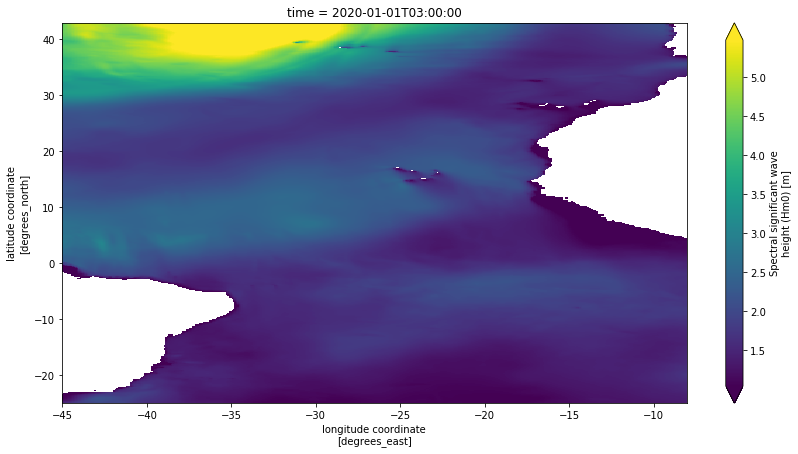

In [41]:
# Extract array from dataset to define the cost in the routing algorithm 
# wave height
wave_height = wav_all.VHM0.isel(time=time_slice, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))
wave_height.plot(robust=True, aspect=2, size=7);

# wave dir
wave_dir = wav_all.VMDR.isel(time=time_slice, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

# temperature
temp = phy_all.thetao.isel(time=time_slice, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max), depth = 0)

# salinity
sal = phy_all.so.isel(time=time_slice, longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max), depth = 0)

### Start and end point of the route

In [42]:
lat_Lis = 38.716666
lon_Lis = -9.1667
lat_Rio = -22.908333
lon_Rio = -43.196389

In [43]:
start_lon = get_closest(wave_height.longitude.data, lon_Lis)
start_lat = get_closest(wave_height.latitude.data, lat_Lis)
end_lon = get_closest(wave_height.longitude.data,lon_Rio)
end_lat = get_closest(wave_height.latitude.data,lat_Rio)

In [46]:
start = (start_lat, start_lon)
end = (end_lat, end_lon)

In [85]:
wh_costs = wave_height.data
# Set NaN values to large wh_costs as the algorithm cannot handle NaNs
wh_costs[np.isnan(wh_costs)] = 2 * np.nanmax(wh_costs) 

wd_costs = wave_dir.data
wd_costs[np.isnan(wd_costs)] = 2 * np.nanmax(wd_costs) 

temp_costs = temp.data
temp_costs[np.isnan(temp_costs)] = 2 * np.nanmax(temp_costs) 

sal_costs = sal.data
sal_costs[np.isnan(sal_costs)] = 2 * np.nanmax(sal_costs) 


# weight come from linear regression
costs = 0.14661334*wh_costs + 0.04047778*wd_costs + 0.13590311*temp_costs + 0.08404383*sal_costs

In [86]:
from skimage.graph import route_through_array

# Calculate optimal route based on the minimum cost path

# Optional parameters:
# - fully_connected 
#     - False -> only axial moves are allowed
#     - True  -> diagonal moves are allowed
# - geometric 
#     - False -> minimum cost path
#     - True  -> distance-weighted minimum cost path

wh_indices, weight = route_through_array(wh_costs, start, end, fully_connected=True, geometric=False)
wh_indices = np.stack(wh_indices, axis=-1)

wd_indices, weight = route_through_array(wd_costs, start, end, fully_connected=True, geometric=False)
wd_indices = np.stack(wd_indices, axis=-1)

temp_indices, weight = route_through_array(temp_costs, start, end, fully_connected=True, geometric=False)
temp_indices = np.stack(temp_indices, axis=-1)

sal_indices, weight = route_through_array(sal_costs, start, end, fully_connected=True, geometric=False)
sal_indices = np.stack(sal_indices, axis=-1)

merged_indices, weight = route_through_array(costs, start, end, fully_connected=True, geometric=False)
merged_indices = np.stack(merged_indices, axis=-1)


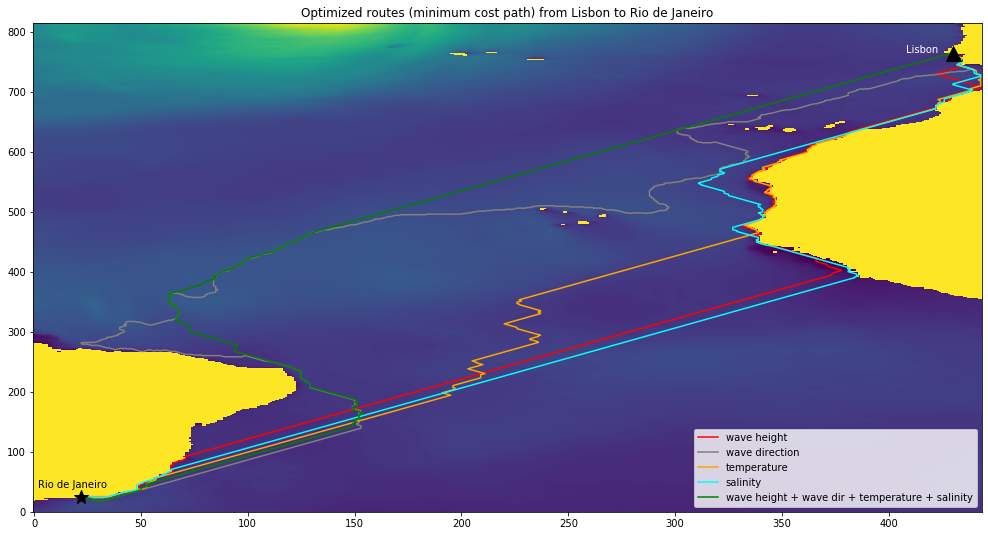

In [87]:
# Plot optimal route

plt.figure(figsize=(17,9))
# Costs
plt.imshow(wh_costs, aspect='auto', vmin=np.min(wh_costs), vmax=0.5*np.max(wh_costs));
# Routes
plt.plot(wh_indices[1],wh_indices[0], 'r', label = "wave height")
plt.plot(wd_indices[1],wd_indices[0],'grey', label = "wave direction")
plt.plot(temp_indices[1],temp_indices[0],'orange', label = "temperature")
plt.plot(sal_indices[1],sal_indices[0],'cyan', label = "salinity")
plt.plot(merged_indices[1],merged_indices[0],'green', label = "wave height + wave dir + temperature + salinity")
# Start/end points
plt.plot(start_lon, start_lat, 'k^', markersize=15)
plt.text(start_lon - 22, start_lat, "Lisbon", color = "white")
plt.plot(end_lon, end_lat, 'k*', markersize=15)
plt.text(end_lon - 20, end_lat +15, "Rio de Janeiro")
plt.title("Optimized routes (minimum cost path) from Lisbon to Rio de Janeiro")
plt.legend(loc = "lower right")
plt.gca().invert_yaxis();

## Advanced solution: Calculate optimal route (minimum cost path) based on *multiple* variables and *multiple* days

In [ ]:
# TODO